# SSL on STL-10: Augmentations Preview (SimCLR-style)

This notebook is a visual sanity-check for the core idea of contrastive self-supervised learning:

**We create two independent augmented views of the same image** and train the encoder to produce similar representations for these two views, while keeping representations of different images apart.

In SimCLR, the quality of augmentations matters a lot: they define *which invariances* the model can learn.
Here we preview the augmentation pipeline used for **STL-10 (unlabeled)**.

**What you should see below:**
- the same image, transformed in two different ways (View #1 / View #2)
- crops, color jitter, grayscale, blur, flips (depending on your pipeline)
- images remain recognizable but nt identical


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import STL10

from src.data.augmentations import SimCLRTransforms

DATA_DIR = PROJECT_ROOT / "data"
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("CUDA available:", torch.cuda.is_available())

PROJECT_ROOT: D:\ML\SSL
DATA_DIR: D:\ML\SSL\data
CUDA available: True


In [2]:
def _to_uint8(img_tensor: torch.Tensor) -> np.ndarray:
    """
    Convert torch image tensor [C,H,W] to uint8 numpy [H,W,C] for matplotlib.
    We try to handle both:
    - [0..1] float
    - normalized tensors (mean/std) by rescaling to [0..1] for display
    """
    x = img_tensor.detach().cpu().float()
    x = (x - x.min()) / (x.max() - x.min() + 1e-12)

    x = (x * 255.0).clamp(0, 255).byte()
    x = x.permute(1, 2, 0).numpy()
    return x


def show_triplet(original, v1, v2, title=None):
    """
    Show original image and two augmented views side by side.
    """
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    if title is not None:
        fig.suptitle(title)

    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(v1)
    axes[1].set_title("View #1")
    axes[1].axis("off")

    axes[2].imshow(v2)
    axes[2].set_title("View #2")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Dataset size: 100000


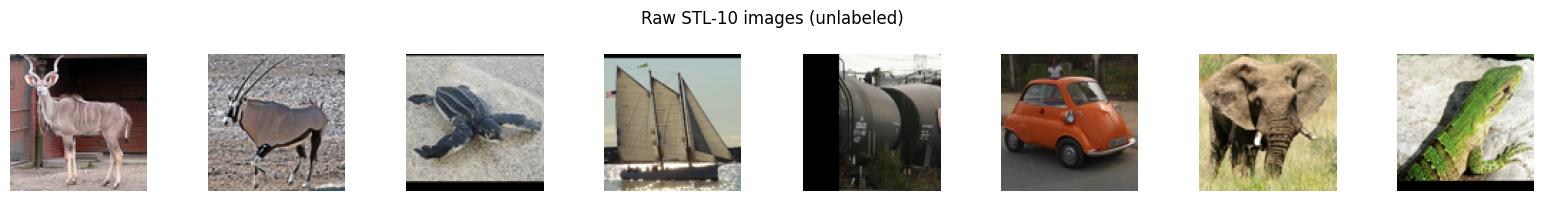

In [3]:
# STL-10 unlabeled split returns (PIL_image, -1)
ds_raw = STL10(root=str(DATA_DIR), split="unlabeled", download=True)

print("Dataset size:", len(ds_raw))

# show a few raw images
n_show = 8
fig, axes = plt.subplots(1, n_show, figsize=(2*n_show, 2))
for i in range(n_show):
    img, _ = ds_raw[i]
    axes[i].imshow(img)
    axes[i].axis("off")
plt.suptitle("Raw STL-10 images (unlabeled)")
plt.tight_layout()
plt.show()

SimCLRTransforms(image_size=96)


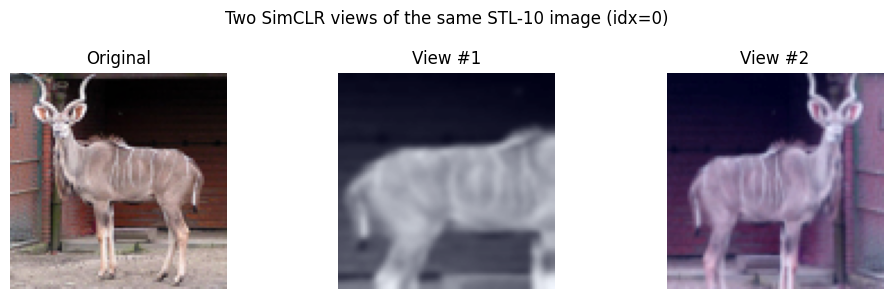

In [6]:
# Build the same augmentation pipeline as in training
tfm = SimCLRTransforms(image_size=96)

print(tfm)

idx = 0
img_pil, _ = ds_raw[idx]
x1, x2 = tfm(img_pil)

original = np.array(img_pil)
v1 = _to_uint8(x1)
v2 = _to_uint8(x2)

show_triplet(original, v1, v2, title=f"Two SimCLR views of the same STL-10 image (idx={idx})")

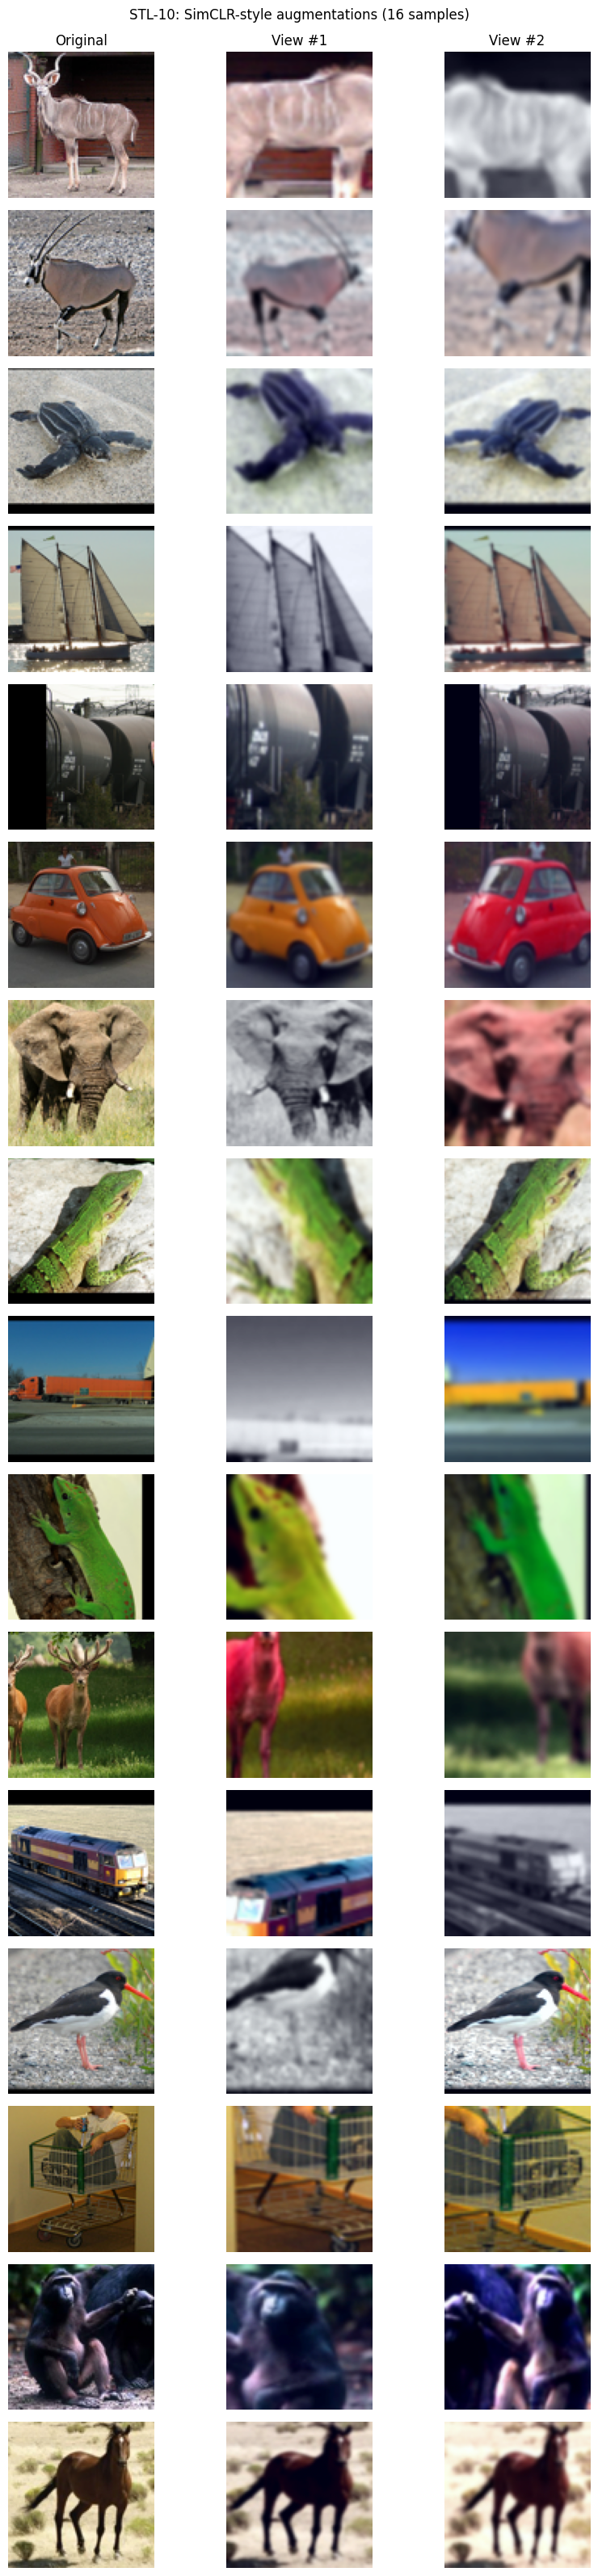

In [5]:
tfm = SimCLRTransforms(image_size=96)

N = 16
indices = list(range(N))

fig, axes = plt.subplots(N, 3, figsize=(9, 2*N))

for row, idx in enumerate(indices):
    img_pil, _ = ds_raw[idx]
    x1, x2 = tfm(img_pil)

    original = np.array(img_pil)
    v1 = _to_uint8(x1)
    v2 = _to_uint8(x2)

    axes[row, 0].imshow(original)
    axes[row, 1].imshow(v1)
    axes[row, 2].imshow(v2)

    for col in range(3):
        axes[row, col].axis("off")

# column titles
axes[0, 0].set_title("Original")
axes[0, 1].set_title("View #1")
axes[0, 2].set_title("View #2")

plt.suptitle("STL-10: SimCLR-style augmentations (16 samples)", y=0.995)
plt.tight_layout()
plt.show()

## Notes / Takeaways

- The two views are **visually different**, but the object identity is generally preserved.
- This is exactly what we want in contrastive SSL: learn representations that are invariant to these transformations.
- Next steps in the project:
  1) Pre-train **SimCLR (ResNet-18 + NT-Xent)** on STL-10 *unlabeled*.
  2) Evaluate learned embeddings via **kNN** and **linear probe** on STL-10 labeled train/test.
  3) Build a simple **retrieval demo** using FAISS (find similar images by embedding similarity).
  4) Add **BYOL** and compare with SimCLR under the same setup.
